# Customer_Segmentation - Modeling (K-Means on RFM)

In [1]:
# Step 4.1: Environment & Inputs
# Step 4.1.1: Load RFM features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Load processed RFM tables
olist_rfm = pd.read_csv("../data/processed/olist_rfm.csv")
northwind_rfm = pd.read_csv("../data/processed/northwind_rfm.csv")

In [3]:
# Step 4.2: Structural Validation
rfm_cols = ["recency", "frequency", "monetary"]

for col in rfm_cols:
    assert col in olist_rfm.columns
    assert col in northwind_rfm.columns

assert olist_rfm[rfm_cols].isna().sum().sum() == 0
assert northwind_rfm[rfm_cols].isna().sum().sum() == 0

print("RFM structure validated.")

RFM structure validated.


In [4]:
# Step 4.3: Feature Selection (RFM only)
X_olist = olist_rfm[rfm_cols]
X_northwind = northwind_rfm[rfm_cols]

In [5]:
# Step 4.4: Feature Scaling (Required for K-Means)
scaler_olist = StandardScaler()
X_olist_scaled = scaler_olist.fit_transform(X_olist)

scaler_nw = StandardScaler()
X_nw_scaled = scaler_nw.fit_transform(X_northwind) #Clustering was performed independently for each dataset using dataset-specific scaling.


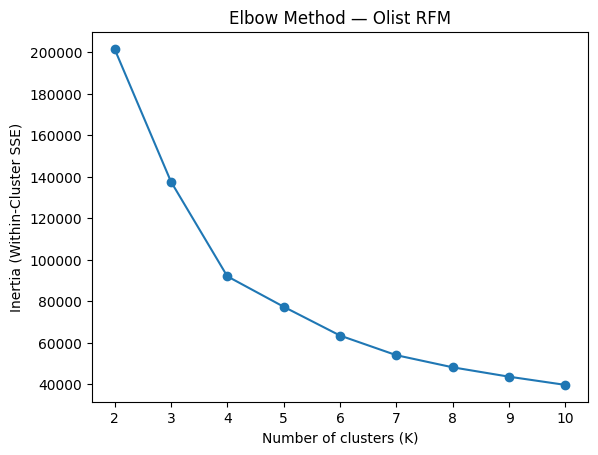

In [6]:
# Step 4.5: Optimal K Selection (Evidence-Based)
# Step 4.5.1: Elbow Method (Olist)
# Step 4.5.1: Elbow Method (Olist)

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_olist_scaled)
    inertia.append(km.inertia_)


plt.figure()
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method — Olist RFM")
plt.savefig("../visuals/olist_elbow_method.png")
plt.show()

### Elbow Curve Interpretation (Objective)

Observation from Elbow Plot:

- Inertia decreases sharply from K = 2 → K = 4

- After K = 4, the curve flattens noticeably

- Marginal improvement beyond K = 4 is small and incremental

#### Interpretation:  

The “elbow” is clearly visible at K = 4  

Beyond this point, adding clusters increases model complexity without proportional reduction in within-cluster variance  

Elbow method suggests: K = 4

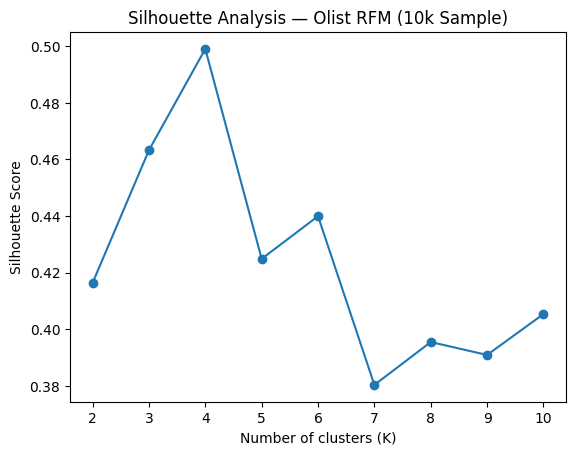

In [7]:
# Step 4.5.2 Silhouette analysis
# Sample max 10,000 customers (industry standard)
# Sample max 10,000 customers (industry standard)
sample_size = min(10000, X_olist_scaled.shape[0])

rng = np.random.RandomState(42)
sample_idx = rng.choice(
    X_olist_scaled.shape[0],
    size=sample_size,
    replace=False
)

X_sample = X_olist_scaled[sample_idx]

silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)


plt.figure()
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis — Olist RFM (10k Sample)")
plt.savefig("../visuals/olist_silhouette_analysis.png")
plt.show()

### Silhouette Score Interpretation (Objective)

Observed silhouette scores:  

K	Silhouette Score
2	~0.42
3	~0.46
4	~0.50 (highest)
5	~0.43
6	~0.44
7–10	≤ 0.40

Interpretation:  

K = 4 produces the highest silhouette score

Indicates:  

- Strong intra-cluster cohesion

- Clear inter-cluster separation

- Scores decline after K = 4 → cluster boundaries worsen  

Silhouette analysis strongly supports: K = 4

In [8]:
# STEP 4.6 — Final K Selection (Evidence-Driven)
k_final = 4
print("Final K selected:", k_final)

Final K selected: 4


In [10]:
# Step 4.7: Final K-Means Model (Olist)
k_final = 4

kmeans_olist = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

olist_clusters = kmeans_olist.fit_predict(X_olist_scaled)

olist_rfm["cluster"] = olist_clusters

In [11]:
# Step 4.8: Cluster Size Sanity Check (Olist)
olist_rfm["cluster"].value_counts().sort_index()

cluster
0    50644
1    37525
2     2772
3     2416
Name: count, dtype: int64

In [12]:
# Step 4.9: Cluster Profiling (Business-Meaningful)
# Step 4.9.1 — Mean RFM by Cluster
olist_cluster_profile = (
    olist_rfm
    .groupby("cluster")[["recency", "frequency", "monetary"]]
    .mean()
    .round(2)
)

olist_cluster_profile

,recency,frequency,monetary
cluster,,,
0,128.08,1.00,134.38
1,387.40,1.00,133.46
2,220.44,2.11,289.68
3,239.46,1.01,1161.33


In [13]:
# Step 4.9.2: Median RFM by Cluster (Robustness)
olist_cluster_profile_median = (
    olist_rfm
    .groupby("cluster")[["recency", "frequency", "monetary"]]
    .median()
    .round(2)
)

olist_cluster_profile_median

,recency,frequency,monetary
cluster,,,
0,129.0,1.0,103.64
1,374.0,1.0,101.34
2,199.0,2.0,223.90
3,225.0,1.0,936.76


In [14]:
# Step 4.10: Business Persona Mapping (RFM Logic)
olist_cluster_profile

,recency,frequency,monetary
cluster,,,
0,128.08,1.00,134.38
1,387.40,1.00,133.46
2,220.44,2.11,289.68
3,239.46,1.01,1161.33


In [15]:
# Step 4.11: Northwind Validation (Structural Comparison)
# Step 4.11.1: Scale Northwind RFM
from sklearn.preprocessing import StandardScaler

scaler_nw = StandardScaler()
X_northwind_scaled = scaler_nw.fit_transform(
    northwind_rfm[["recency", "frequency", "monetary"]]
)

In [16]:
# STEP 4.11.2: Northwind Validation (SAME K)
kmeans_nw = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

northwind_clusters = kmeans_nw.fit_predict(X_northwind_scaled)

northwind_rfm["cluster"] = northwind_clusters


In [17]:
# Step 4.11.3: Structural Comparison (Validation)
northwind_cluster_profile = (
    northwind_rfm
    .groupby("cluster")[["recency", "frequency", "monetary"]]
    .mean()
    .round(2)
)

northwind_cluster_profile

,recency,frequency,monetary
cluster,,,
0,23.46,13.82,22777.56
1,53.25,6.27,5500.88
2,504.00,1.50,228.90
3,10.33,29.67,106504.74


In [18]:
# Step 4.11: Save Outputs
olist_rfm.to_csv(
    "../data/processed/olist_rfm_with_clusters.csv",
    index=False
)

northwind_rfm.to_csv(
    "../data/processed/northwind_rfm_with_clusters.csv",
    index=False
)